# Lab - RNNs, LSTMs and GRUs

Repeat the sentiment analysis exercise from Lab 2. For this one you will consider the following models:
* RNN
* LSTM
* GRU

Compare the results with each other and the Naive Bayes model obtained in Lab 2. The group with the best weighted F1 score gets 3 extra points to the final grade, the second best get 2 points, and the third gets 1 point. To simplify, consider only 3 categories: negative, neutral and positive.

To split the data use:


* random_state=13
* test_size=0.2
* stratified split


Authors:

* Kuntur Muenala
* Diego Villacreses

In [ ]:
# !pip install skopt
# !pip install scikit-optimize

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import spacy

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
#from skopt import BayesSearchCV
#from skopt.space import Real, Integer
  # Intento fallido de optimización bayesiana sobre hyperparámetros de Naive Bayes

import time
import seaborn as sns

os.chdir("/home/dvillacreses/nlp")
print(f"{os.getcwd()=}")

os.getcwd()='/home/dvillacreses/nlp'


## Load Data

Dataset:
* https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator, GloVe
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device= 'cpu'

# Tokenizer
tokenizer = get_tokenizer("spacy", language="en_core_web_sm")

# Function to yield tokens from phrases for vocabulary building
def yield_tokens(phrases):
    for phrase in phrases:
        yield tokenizer(phrase)

# Custom dataset class
class MovieReviewsDataset(Dataset):
    def __init__(self, phrases, sentiments, vocab, max_len=100):
        self.phrases = phrases
        self.sentiments = sentiments
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.phrases)

    def __getitem__(self, idx):
        phrase = self.phrases[idx]
        sentiment = self.sentiments[idx]
        tokens = tokenizer(phrase)
        token_ids = [self.vocab[token] if token in self.vocab else self.vocab["<unk>"] for token in tokens]
        # Padding or truncation
        if len(token_ids) > self.max_len:
            token_ids = token_ids[:self.max_len]
        else:
            token_ids += [self.vocab["<pad>"]] * (self.max_len - len(token_ids))

        return torch.tensor(token_ids), torch.tensor(sentiment, dtype=torch.long)

# Preprocessing the data
def preprocess_data(file_path):
    df = pd.read_csv(file_path, delimiter='\t')

    df = df[['Phrase', 'Sentiment']]
    recode_dict = {0:1,1:1,2:2,3:3,4:3}
    df = df.replace({'Sentiment': recode_dict})

    return df['Phrase'].values, df['Sentiment'].values

# Load data
phrases, sentiments = preprocess_data('train.tsv')

# Split the data
train_phrases, valid_phrases, train_sentiments, valid_sentiments = train_test_split(phrases, sentiments, test_size=0.2, random_state=13, stratify=sentiments)

# Build the vocabulary
vocab = build_vocab_from_iterator(yield_tokens(train_phrases), specials=["<unk>", "<pad>"])
vocab.set_default_index(vocab["<unk>"])

# Load GloVe vectors
glove_vectors = GloVe(name="6B", dim=100)

# Create datasets
train_dataset = MovieReviewsDataset(train_phrases, train_sentiments, vocab)
valid_dataset = MovieReviewsDataset(valid_phrases, valid_sentiments, vocab)

/usr/local/lib/python3.10/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated

In [ ]:
pd.Series(train_dataset.sentiments).value_counts(normalize=True)

2    0.509948
3    0.269976
1    0.220076
Name: proportion, dtype: float64

In [ ]:
pd.Series(valid_dataset.sentiments).value_counts(normalize=True)

2    0.509932
3    0.269992
1    0.220076
Name: proportion, dtype: float64

## LSTM

### General LSTM

In [5]:
# Define the LSTM model
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx):
        super(SentimentLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers,
                            bidirectional=bidirectional, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, (hidden, cell) = self.lstm(embedded)

        if self.lstm.bidirectional:
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
            hidden = hidden[-1,:,:]

        hidden = self.dropout(hidden)
        return self.fc(hidden)

# Accuracy calculation function
def multi_class_accuracy(preds, y):
    """
    Returns accuracy per batch.
    Get the class with the highest probability and compare it with the true class.
    """
    max_preds = preds.argmax(dim=1, keepdim=True)  # get the index of the max probability
    correct = max_preds.squeeze(1).eq(y)
    return correct.sum().float() / torch.FloatTensor([y.shape[0]]).to(y.device)

# Training function
def train(model, loader, optimizer, criterion):
    model.train()
    epoch_loss = 0
    epoch_acc = 0

    for text, sentiment in loader:
        text, sentiment = text.to(device), sentiment.to(device)
        optimizer.zero_grad()
        predictions = model(text)
        loss = criterion(predictions, sentiment)
        acc = multi_class_accuracy(predictions, sentiment)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(loader), epoch_acc / len(loader)

# Evaluation function
def evaluate(model, loader, criterion):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    all_preds = []
    with torch.no_grad():
        for text, sentiment in loader:
            text, sentiment = text.to(device), sentiment.to(device)
            predictions = model(text)
            loss = criterion(predictions, sentiment)
            acc = multi_class_accuracy(predictions, sentiment)
            y_hat = predictions.argmax(dim=1, keepdim=True)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            all_preds.append(y_hat)

    return epoch_loss / len(loader), epoch_acc / len(loader), all_preds


In [ ]:


# Model hyperparameters
# Initialize the model
INPUT_DIM = len(vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 5
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = vocab["<pad>"]
BATCH_SIZE = 64

# Model
model = SentimentLSTM(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX).to(device)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)

# Use pretrained embeddings
embedding_matrix = torch.zeros(INPUT_DIM, EMBEDDING_DIM)
for i, token in enumerate(vocab.get_itos()):
    if token in glove_vectors.stoi:
        embedding_matrix[i] = glove_vectors[token]
model.embedding.weight.data.copy_(embedding_matrix)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss().to(device)


# Training loop
N_EPOCHS = 10
nn_res = []
for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc,all_preds = evaluate(model, valid_loader, criterion)

    y_hat_val = []
    for n in range(len(all_preds)):
      y_hat_val += [i[0] for i in all_preds[n].cpu().numpy()]

    f1_w = f1_score(y_true=valid_dataset.sentiments,
         y_pred=y_hat_val,
         average='weighted')

    print(f'Epoch {epoch+1}')
    print(f'Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'Valid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:.2f}% | Valid F1-Weighted: {f1_w*100:.2f}%')

    nn_res.append([epoch,train_loss,train_acc,valid_loss,valid_acc,f1_w])

Epoch 1
Train Loss: 0.767 | Train Acc: 66.51%
Valid Loss: 0.650 | Valid Acc: 72.78% | Valid F1-Weighted: 72.39%
Epoch 2
Train Loss: 0.648 | Train Acc: 72.63%
Valid Loss: 0.607 | Valid Acc: 74.51% | Valid F1-Weighted: 74.55%
Epoch 3
Train Loss: 0.599 | Train Acc: 75.00%
Valid Loss: 0.588 | Valid Acc: 76.03% | Valid F1-Weighted: 76.02%
Epoch 4
Train Loss: 0.558 | Train Acc: 76.84%
Valid Loss: 0.573 | Valid Acc: 76.41% | Valid F1-Weighted: 76.32%
Epoch 5
Train Loss: 0.531 | Train Acc: 78.02%
Valid Loss: 0.571 | Valid Acc: 76.96% | Valid F1-Weighted: 76.91%
Epoch 6
Train Loss: 0.510 | Train Acc: 78.86%
Valid Loss: 0.575 | Valid Acc: 76.91% | Valid F1-Weighted: 76.89%
Epoch 7
Train Loss: 0.490 | Train Acc: 79.86%
Valid Loss: 0.602 | Valid Acc: 76.49% | Valid F1-Weighted: 76.52%
Epoch 8
Train Loss: 0.474 | Train Acc: 80.23%
Valid Loss: 0.576 | Valid Acc: 76.96% | Valid F1-Weighted: 76.95%
Epoch 9
Train Loss: 0.461 | Train Acc: 80.86%
Valid Loss: 0.598 | Valid Acc: 76.93% | Valid F1-Weighted:

### Manual HPO

In [ ]:
# Model hyperparameters
# Initialize the model
INPUT_DIM = len(vocab)
EMBEDDING_DIM = 200
HIDDEN_DIM = 256
OUTPUT_DIM = 5
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = vocab["<pad>"]
BATCH_SIZE = 32

# Model
model = SentimentLSTM(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX).to(device)

glove_vectors = GloVe(name="6B", dim=EMBEDDING_DIM)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)

# Use pretrained embeddings
embedding_matrix = torch.zeros(INPUT_DIM, EMBEDDING_DIM)
for i, token in enumerate(vocab.get_itos()):
    if token in glove_vectors.stoi:
        embedding_matrix[i] = glove_vectors[token]
model.embedding.weight.data.copy_(embedding_matrix)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss().to(device)


# Training loop
N_EPOCHS = 10
nn_res = []
for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc,all_preds = evaluate(model, valid_loader, criterion)

    y_hat_val = []
    for n in range(len(all_preds)):
      y_hat_val += [i[0] for i in all_preds[n].cpu().numpy()]

    f1_w = f1_score(y_true=valid_dataset.sentiments,
         y_pred=y_hat_val,
         average='weighted')

    print(f'Epoch {epoch+1}')
    print(f'Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'Valid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:.2f}% | Valid F1-Weighted: {f1_w*100:.2f}%')

    nn_res.append([epoch,train_loss,train_acc,valid_loss,valid_acc,f1_w])

Epoch 1
Train Loss: 0.720 | Train Acc: 68.92%
Valid Loss: 0.625 | Valid Acc: 74.01% | Valid F1-Weighted: 74.06%
Epoch 2
Train Loss: 0.602 | Train Acc: 75.01%
Valid Loss: 0.575 | Valid Acc: 76.42% | Valid F1-Weighted: 76.36%
Epoch 3
Train Loss: 0.547 | Train Acc: 77.30%
Valid Loss: 0.570 | Valid Acc: 76.71% | Valid F1-Weighted: 76.71%
Epoch 4
Train Loss: 0.513 | Train Acc: 78.89%
Valid Loss: 0.569 | Valid Acc: 76.93% | Valid F1-Weighted: 76.87%
Epoch 5
Train Loss: 0.492 | Train Acc: 79.84%
Valid Loss: 0.584 | Valid Acc: 76.82% | Valid F1-Weighted: 76.82%
Epoch 6
Train Loss: 0.467 | Train Acc: 80.96%
Valid Loss: 0.583 | Valid Acc: 76.95% | Valid F1-Weighted: 76.92%
Epoch 7
Train Loss: 0.448 | Train Acc: 81.52%
Valid Loss: 0.605 | Valid Acc: 76.91% | Valid F1-Weighted: 76.93%
Epoch 8
Train Loss: 0.431 | Train Acc: 82.25%
Valid Loss: 0.629 | Valid Acc: 76.34% | Valid F1-Weighted: 76.37%
Epoch 9
Train Loss: 0.417 | Train Acc: 82.83%
Valid Loss: 0.620 | Valid Acc: 76.52% | Valid F1-Weighted:

In [ ]:
# Model hyperparameters
# Initialize the model
INPUT_DIM = len(vocab)
EMBEDDING_DIM = 200
HIDDEN_DIM = 300
OUTPUT_DIM = 5
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = vocab["<pad>"]
BATCH_SIZE = 32

# Model
model = SentimentLSTM(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX).to(device)

glove_vectors = GloVe(name="6B", dim=EMBEDDING_DIM)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)

# Use pretrained embeddings
embedding_matrix = torch.zeros(INPUT_DIM, EMBEDDING_DIM)
for i, token in enumerate(vocab.get_itos()):
    if token in glove_vectors.stoi:
        embedding_matrix[i] = glove_vectors[token]
model.embedding.weight.data.copy_(embedding_matrix)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss().to(device)


# Training loop
N_EPOCHS = 10
nn_res = []
for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc,all_preds = evaluate(model, valid_loader, criterion)

    y_hat_val = []
    for n in range(len(all_preds)):
      y_hat_val += [i[0] for i in all_preds[n].cpu().numpy()]

    f1_w = f1_score(y_true=valid_dataset.sentiments,
         y_pred=y_hat_val,
         average='weighted')

    print(f'Epoch {epoch+1}')
    print(f'Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'Valid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:.2f}% | Valid F1-Weighted: {f1_w*100:.2f}%')

    nn_res.append([epoch,train_loss,train_acc,valid_loss,valid_acc,f1_w])

Epoch 1
Train Loss: 0.719 | Train Acc: 69.06%
Valid Loss: 0.609 | Valid Acc: 74.93% | Valid F1-Weighted: 74.83%
Epoch 2
Train Loss: 0.599 | Train Acc: 75.04%
Valid Loss: 0.581 | Valid Acc: 75.99% | Valid F1-Weighted: 75.92%
Epoch 3
Train Loss: 0.550 | Train Acc: 77.34%
Valid Loss: 0.573 | Valid Acc: 76.52% | Valid F1-Weighted: 76.53%
Epoch 4
Train Loss: 0.509 | Train Acc: 79.16%
Valid Loss: 0.577 | Valid Acc: 76.66% | Valid F1-Weighted: 76.64%
Epoch 5
Train Loss: 0.483 | Train Acc: 80.18%
Valid Loss: 0.586 | Valid Acc: 76.87% | Valid F1-Weighted: 76.86%
Epoch 6
Train Loss: 0.460 | Train Acc: 81.12%
Valid Loss: 0.596 | Valid Acc: 76.53% | Valid F1-Weighted: 76.56%
Epoch 7
Train Loss: 0.444 | Train Acc: 81.85%
Valid Loss: 0.628 | Valid Acc: 76.49% | Valid F1-Weighted: 76.52%
Epoch 8
Train Loss: 0.427 | Train Acc: 82.37%
Valid Loss: 0.637 | Valid Acc: 76.45% | Valid F1-Weighted: 76.44%
Epoch 9
Train Loss: 0.413 | Train Acc: 82.92%
Valid Loss: 0.656 | Valid Acc: 76.58% | Valid F1-Weighted:

In [ ]:
# Model hyperparameters
# Initialize the model
INPUT_DIM = len(vocab)
EMBEDDING_DIM = 200
HIDDEN_DIM = 300
OUTPUT_DIM = 5
N_LAYERS = 2
BIDIRECTIONAL = False
DROPOUT = 0.5
PAD_IDX = vocab["<pad>"]
BATCH_SIZE = 32

# Model
model = SentimentLSTM(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX).to(device)

glove_vectors = GloVe(name="6B", dim=EMBEDDING_DIM)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)

# Use pretrained embeddings
embedding_matrix = torch.zeros(INPUT_DIM, EMBEDDING_DIM)
for i, token in enumerate(vocab.get_itos()):
    if token in glove_vectors.stoi:
        embedding_matrix[i] = glove_vectors[token]
model.embedding.weight.data.copy_(embedding_matrix)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss().to(device)


# Training loop
N_EPOCHS = 10
nn_res = []
for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc,all_preds = evaluate(model, valid_loader, criterion)

    y_hat_val = []
    for n in range(len(all_preds)):
      y_hat_val += [i[0] for i in all_preds[n].cpu().numpy()]

    f1_w = f1_score(y_true=valid_dataset.sentiments,
         y_pred=y_hat_val,
         average='weighted')

    print(f'Epoch {epoch+1}')
    print(f'Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'Valid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:.2f}% | Valid F1-Weighted: {f1_w*100:.2f}%')

    nn_res.append([epoch,train_loss,train_acc,valid_loss,valid_acc,f1_w])

Epoch 1
Train Loss: 1.036 | Train Acc: 50.92%
Valid Loss: 1.031 | Valid Acc: 50.99% | Valid F1-Weighted: 34.44%
Epoch 2
Train Loss: 1.032 | Train Acc: 50.99%
Valid Loss: 1.031 | Valid Acc: 50.99% | Valid F1-Weighted: 34.44%
Epoch 3
Train Loss: 1.031 | Train Acc: 50.99%
Valid Loss: 1.030 | Valid Acc: 50.99% | Valid F1-Weighted: 34.44%
Epoch 4
Train Loss: 1.031 | Train Acc: 50.99%
Valid Loss: 1.030 | Valid Acc: 50.99% | Valid F1-Weighted: 34.44%
Epoch 5
Train Loss: 1.031 | Train Acc: 50.99%
Valid Loss: 1.030 | Valid Acc: 50.99% | Valid F1-Weighted: 34.44%
Epoch 6
Train Loss: 1.031 | Train Acc: 50.99%
Valid Loss: 1.030 | Valid Acc: 50.99% | Valid F1-Weighted: 34.44%
Epoch 7
Train Loss: 1.030 | Train Acc: 50.99%
Valid Loss: 1.030 | Valid Acc: 50.99% | Valid F1-Weighted: 34.44%
Epoch 8
Train Loss: 1.308 | Train Acc: 50.80%
Valid Loss: 1.030 | Valid Acc: 50.99% | Valid F1-Weighted: 34.44%
Epoch 9
Train Loss: 1.033 | Train Acc: 50.89%
Valid Loss: 1.031 | Valid Acc: 50.99% | Valid F1-Weighted:

In [ ]:
# Model hyperparameters
# Initialize the model
INPUT_DIM = len(vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 5
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = vocab["<pad>"]
BATCH_SIZE = 32

# Model
model = SentimentLSTM(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX).to(device)

glove_vectors = GloVe(name="6B", dim=EMBEDDING_DIM)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)

# Use pretrained embeddings
embedding_matrix = torch.zeros(INPUT_DIM, EMBEDDING_DIM)
for i, token in enumerate(vocab.get_itos()):
    if token in glove_vectors.stoi:
        embedding_matrix[i] = glove_vectors[token]
model.embedding.weight.data.copy_(embedding_matrix)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss().to(device)


# Training loop
N_EPOCHS = 10
nn_res = []
for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc,all_preds = evaluate(model, valid_loader, criterion)

    y_hat_val = []
    for n in range(len(all_preds)):
      y_hat_val += [i[0] for i in all_preds[n].cpu().numpy()]

    f1_w = f1_score(y_true=valid_dataset.sentiments,
         y_pred=y_hat_val,
         average='weighted')

    print(f'Epoch {epoch+1}')
    print(f'Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'Valid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:.2f}% | Valid F1-Weighted: {f1_w*100:.2f}%')

    nn_res.append([epoch,train_loss,train_acc,valid_loss,valid_acc,f1_w])

Epoch 1
Train Loss: 0.754 | Train Acc: 67.08%
Valid Loss: 0.636 | Valid Acc: 73.43% | Valid F1-Weighted: 73.00%
Epoch 2
Train Loss: 0.635 | Train Acc: 73.40%
Valid Loss: 0.591 | Valid Acc: 75.61% | Valid F1-Weighted: 75.51%
Epoch 3
Train Loss: 0.582 | Train Acc: 75.89%
Valid Loss: 0.577 | Valid Acc: 76.29% | Valid F1-Weighted: 76.27%
Epoch 4
Train Loss: 0.548 | Train Acc: 77.28%
Valid Loss: 0.574 | Valid Acc: 76.55% | Valid F1-Weighted: 76.56%
Epoch 5
Train Loss: 0.521 | Train Acc: 78.66%
Valid Loss: 0.582 | Valid Acc: 76.89% | Valid F1-Weighted: 76.88%
Epoch 6
Train Loss: 0.502 | Train Acc: 79.34%
Valid Loss: 0.580 | Valid Acc: 77.02% | Valid F1-Weighted: 77.01%
Epoch 7
Train Loss: 0.485 | Train Acc: 80.17%
Valid Loss: 0.578 | Valid Acc: 77.00% | Valid F1-Weighted: 76.99%
Epoch 8
Train Loss: 0.470 | Train Acc: 80.68%
Valid Loss: 0.596 | Valid Acc: 76.87% | Valid F1-Weighted: 76.87%
Epoch 9
Train Loss: 0.457 | Train Acc: 81.27%
Valid Loss: 0.611 | Valid Acc: 76.55% | Valid F1-Weighted:

In [ ]:
# Model hyperparameters
# Initialize the model
INPUT_DIM = len(vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 5
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = vocab["<pad>"]
BATCH_SIZE = 32

# Model
model = SentimentLSTM(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX).to(device)

glove_vectors = GloVe(name="6B", dim=EMBEDDING_DIM)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)

# Use pretrained embeddings
embedding_matrix = torch.zeros(INPUT_DIM, EMBEDDING_DIM)
for i, token in enumerate(vocab.get_itos()):
    if token in glove_vectors.stoi:
        embedding_matrix[i] = glove_vectors[token]
model.embedding.weight.data.copy_(embedding_matrix)

# Define optimizer and loss function
optimizer = optim.Adam(lr = 0.0001,params=model.parameters())
criterion = nn.CrossEntropyLoss().to(device)


# Training loop
N_EPOCHS = 20
nn_res = []
for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc,all_preds = evaluate(model, valid_loader, criterion)

    y_hat_val = []
    for n in range(len(all_preds)):
      y_hat_val += [i[0] for i in all_preds[n].cpu().numpy()]

    f1_w = f1_score(y_true=valid_dataset.sentiments,
         y_pred=y_hat_val,
         average='weighted')

    print(f'Epoch {epoch+1}')
    print(f'Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'Valid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:.2f}% | Valid F1-Weighted: {f1_w*100:.2f}%')

    nn_res.append([epoch,train_loss,train_acc,valid_loss,valid_acc,f1_w])

Epoch 1
Train Loss: 0.851 | Train Acc: 61.77%
Valid Loss: 0.752 | Valid Acc: 67.35% | Valid F1-Weighted: 65.87%
Epoch 2
Train Loss: 0.771 | Train Acc: 66.17%
Valid Loss: 0.707 | Valid Acc: 69.93% | Valid F1-Weighted: 69.27%
Epoch 3
Train Loss: 0.736 | Train Acc: 68.19%
Valid Loss: 0.672 | Valid Acc: 71.60% | Valid F1-Weighted: 71.26%
Epoch 4
Train Loss: 0.709 | Train Acc: 69.34%
Valid Loss: 0.653 | Valid Acc: 72.50% | Valid F1-Weighted: 72.31%
Epoch 5
Train Loss: 0.690 | Train Acc: 70.32%
Valid Loss: 0.644 | Valid Acc: 73.12% | Valid F1-Weighted: 73.00%
Epoch 6
Train Loss: 0.672 | Train Acc: 71.26%
Valid Loss: 0.639 | Valid Acc: 72.98% | Valid F1-Weighted: 72.86%
Epoch 7
Train Loss: 0.658 | Train Acc: 71.86%
Valid Loss: 0.619 | Valid Acc: 74.22% | Valid F1-Weighted: 74.18%
Epoch 8
Train Loss: 0.642 | Train Acc: 72.78%
Valid Loss: 0.615 | Valid Acc: 74.43% | Valid F1-Weighted: 74.29%
Epoch 9
Train Loss: 0.631 | Train Acc: 73.16%
Valid Loss: 0.613 | Valid Acc: 74.56% | Valid F1-Weighted:

In [ ]:
# Model hyperparameters
# Initialize the model
INPUT_DIM = len(vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 256
OUTPUT_DIM = 5
N_LAYERS = 3
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = vocab["<pad>"]
BATCH_SIZE = 32

# Model
model = SentimentLSTM(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX).to(device)

glove_vectors = GloVe(name="6B", dim=EMBEDDING_DIM)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)

# Use pretrained embeddings
embedding_matrix = torch.zeros(INPUT_DIM, EMBEDDING_DIM)
for i, token in enumerate(vocab.get_itos()):
    if token in glove_vectors.stoi:
        embedding_matrix[i] = glove_vectors[token]
model.embedding.weight.data.copy_(embedding_matrix)

# Define optimizer and loss function
optimizer = optim.Adam(lr = 0.0001,params=model.parameters())
criterion = nn.CrossEntropyLoss().to(device)


# Training loop
N_EPOCHS = 30
nn_res = []
for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc,all_preds = evaluate(model, valid_loader, criterion)

    y_hat_val = []
    for n in range(len(all_preds)):
      y_hat_val += [i[0] for i in all_preds[n].cpu().numpy()]

    f1_w = f1_score(y_true=valid_dataset.sentiments,
         y_pred=y_hat_val,
         average='weighted')

    print(f'Epoch {epoch+1}')
    print(f'Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'Valid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:.2f}% | Valid F1-Weighted: {f1_w*100:.2f}%')

    nn_res.append([epoch,train_loss,train_acc,valid_loss,valid_acc,f1_w])

100%|█████████▉| 399999/400000 [00:31<00:00, 12592.60it/s]


## RNN

In [ ]:
class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx):
        super(SentimentRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=n_layers,
                          bidirectional=bidirectional, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, hidden = self.rnn(embedded)

        if self.rnn.bidirectional:
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
            hidden = hidden[-1,:,:]

        hidden = self.dropout(hidden)
        return self.fc(hidden)

In [ ]:
# Model hyperparameters
# Initialize the model
INPUT_DIM = len(vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 5
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = vocab["<pad>"]
BATCH_SIZE = 64

# Model
model = SentimentRNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX).to(device)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)

# Use pretrained embeddings
embedding_matrix = torch.zeros(INPUT_DIM, EMBEDDING_DIM)
for i, token in enumerate(vocab.get_itos()):
    if token in glove_vectors.stoi:
        embedding_matrix[i] = glove_vectors[token]
model.embedding.weight.data.copy_(embedding_matrix)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss().to(device)


# Training loop
N_EPOCHS = 10
nn_res = []
for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc,all_preds = evaluate(model, valid_loader, criterion)

    y_hat_val = []
    for n in range(len(all_preds)):
      y_hat_val += [i[0] for i in all_preds[n].cpu().numpy()]

    f1_w = f1_score(y_true=valid_dataset.sentiments,
         y_pred=y_hat_val,
         average='weighted')

    print(f'Epoch {epoch+1}')
    print(f'Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'Valid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:.2f}% | Valid F1-Weighted: {f1_w*100:.2f}%')

    nn_res.append([epoch,train_loss,train_acc,valid_loss,valid_acc,f1_w])

Epoch 1
Train Loss: 0.913 | Train Acc: 57.80%
Valid Loss: 0.760 | Valid Acc: 67.10% | Valid F1-Weighted: 65.43%
Epoch 2
Train Loss: 0.781 | Train Acc: 66.00%
Valid Loss: 0.720 | Valid Acc: 68.85% | Valid F1-Weighted: 67.51%
Epoch 3
Train Loss: 0.718 | Train Acc: 69.53%
Valid Loss: 0.664 | Valid Acc: 72.48% | Valid F1-Weighted: 72.15%
Epoch 4
Train Loss: 0.690 | Train Acc: 71.01%
Valid Loss: 0.646 | Valid Acc: 73.53% | Valid F1-Weighted: 73.58%
Epoch 5
Train Loss: 0.677 | Train Acc: 71.75%
Valid Loss: 0.671 | Valid Acc: 72.69% | Valid F1-Weighted: 72.32%
Epoch 6
Train Loss: 0.652 | Train Acc: 72.91%
Valid Loss: 0.675 | Valid Acc: 72.73% | Valid F1-Weighted: 72.62%
Epoch 7
Train Loss: 0.642 | Train Acc: 73.66%
Valid Loss: 0.652 | Valid Acc: 73.82% | Valid F1-Weighted: 73.82%
Epoch 8
Train Loss: 0.624 | Train Acc: 74.50%
Valid Loss: 0.639 | Valid Acc: 73.62% | Valid F1-Weighted: 73.45%
Epoch 9
Train Loss: 0.624 | Train Acc: 74.57%
Valid Loss: 0.642 | Valid Acc: 73.47% | Valid F1-Weighted:

## GRU

In [3]:
class SentimentGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx):
        super(SentimentGRU, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=n_layers,
                          bidirectional=bidirectional, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, hidden = self.gru(embedded)

        if self.gru.bidirectional:
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
            hidden = hidden[-1,:,:]

        hidden = self.dropout(hidden)
        return self.fc(hidden)


In [ ]:

# Model hyperparameters
# Initialize the model
INPUT_DIM = len(vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 5
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = vocab["<pad>"]
BATCH_SIZE = 64

# Model
model = SentimentGRU(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX).to(device)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)

# Use pretrained embeddings
embedding_matrix = torch.zeros(INPUT_DIM, EMBEDDING_DIM)
for i, token in enumerate(vocab.get_itos()):
    if token in glove_vectors.stoi:
        embedding_matrix[i] = glove_vectors[token]
model.embedding.weight.data.copy_(embedding_matrix)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss().to(device)


# Training loop
N_EPOCHS = 10
nn_res = []
for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc,all_preds = evaluate(model, valid_loader, criterion)

    y_hat_val = []
    for n in range(len(all_preds)):
      y_hat_val += [i[0] for i in all_preds[n].cpu().numpy()]

    f1_w = f1_score(y_true=valid_dataset.sentiments,
         y_pred=y_hat_val,
         average='weighted')

    print(f'Epoch {epoch+1}')
    print(f'Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'Valid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:.2f}% | Valid F1-Weighted: {f1_w*100:.2f}%')

    nn_res.append([epoch,train_loss,train_acc,valid_loss,valid_acc,f1_w])

Epoch 1
Train Loss: 0.763 | Train Acc: 66.66%
Valid Loss: 0.633 | Valid Acc: 73.52% | Valid F1-Weighted: 73.52%
Epoch 2
Train Loss: 0.650 | Train Acc: 72.41%
Valid Loss: 0.597 | Valid Acc: 75.15% | Valid F1-Weighted: 75.10%
Epoch 3
Train Loss: 0.599 | Train Acc: 74.83%
Valid Loss: 0.579 | Valid Acc: 76.44% | Valid F1-Weighted: 76.45%
Epoch 4
Train Loss: 0.562 | Train Acc: 76.65%
Valid Loss: 0.579 | Valid Acc: 75.89% | Valid F1-Weighted: 75.92%
Epoch 5
Train Loss: 0.536 | Train Acc: 77.87%
Valid Loss: 0.569 | Valid Acc: 76.99% | Valid F1-Weighted: 76.94%
Epoch 6
Train Loss: 0.516 | Train Acc: 78.68%
Valid Loss: 0.574 | Valid Acc: 76.53% | Valid F1-Weighted: 76.57%
Epoch 7
Train Loss: 0.500 | Train Acc: 79.31%
Valid Loss: 0.577 | Valid Acc: 76.29% | Valid F1-Weighted: 76.32%
Epoch 8
Train Loss: 0.485 | Train Acc: 79.96%
Valid Loss: 0.582 | Valid Acc: 76.83% | Valid F1-Weighted: 76.71%
Epoch 9
Train Loss: 0.474 | Train Acc: 80.47%
Valid Loss: 0.595 | Valid Acc: 76.84% | Valid F1-Weighted:

In [ ]:

# Model hyperparameters
# Initialize the model
INPUT_DIM = len(vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 5
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = vocab["<pad>"]
BATCH_SIZE = 64

# Model
model = SentimentGRU(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX).to(device)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)

# Use pretrained embeddings
embedding_matrix = torch.zeros(INPUT_DIM, EMBEDDING_DIM)
for i, token in enumerate(vocab.get_itos()):
    if token in glove_vectors.stoi:
        embedding_matrix[i] = glove_vectors[token]
model.embedding.weight.data.copy_(embedding_matrix)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss().to(device)


# Training loop
N_EPOCHS = 15
nn_res = []
for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc,all_preds = evaluate(model, valid_loader, criterion)

    y_hat_val = []
    for n in range(len(all_preds)):
      y_hat_val += [i[0] for i in all_preds[n].cpu().numpy()]

    f1_w = f1_score(y_true=valid_dataset.sentiments,
         y_pred=y_hat_val,
         average='weighted')

    print(f'Epoch {epoch+1}')
    print(f'Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'Valid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:.2f}% | Valid F1-Weighted: {f1_w*100:.2f}%')

    nn_res.append([epoch,train_loss,train_acc,valid_loss,valid_acc,f1_w])

Epoch 1
Train Loss: 0.763 | Train Acc: 66.62%
Valid Loss: 0.636 | Valid Acc: 73.67% | Valid F1-Weighted: 73.49%
Epoch 2
Train Loss: 0.651 | Train Acc: 72.31%
Valid Loss: 0.593 | Valid Acc: 75.39% | Valid F1-Weighted: 75.34%
Epoch 3
Train Loss: 0.599 | Train Acc: 74.75%
Valid Loss: 0.593 | Valid Acc: 75.67% | Valid F1-Weighted: 75.44%
Epoch 4
Train Loss: 0.564 | Train Acc: 76.55%
Valid Loss: 0.586 | Valid Acc: 75.89% | Valid F1-Weighted: 75.84%
Epoch 5
Train Loss: 0.540 | Train Acc: 77.57%
Valid Loss: 0.580 | Valid Acc: 76.88% | Valid F1-Weighted: 76.78%
Epoch 6
Train Loss: 0.518 | Train Acc: 78.58%
Valid Loss: 0.577 | Valid Acc: 76.89% | Valid F1-Weighted: 76.90%
Epoch 7
Train Loss: 0.498 | Train Acc: 79.41%
Valid Loss: 0.577 | Valid Acc: 76.72% | Valid F1-Weighted: 76.76%
Epoch 8
Train Loss: 0.486 | Train Acc: 79.96%
Valid Loss: 0.585 | Valid Acc: 77.06% | Valid F1-Weighted: 77.07%
Epoch 9
Train Loss: 0.473 | Train Acc: 80.50%
Valid Loss: 0.587 | Valid Acc: 77.02% | Valid F1-Weighted:

In [6]:

# Model hyperparameters
# Initialize the model
INPUT_DIM = len(vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 5
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = vocab["<pad>"]
BATCH_SIZE = 64

# Model
model = SentimentGRU(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX).to(device)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)

# # Use pretrained embeddings
# embedding_matrix = torch.zeros(INPUT_DIM, EMBEDDING_DIM)
# for i, token in enumerate(vocab.get_itos()):
#     if token in glove_vectors.stoi:
#         embedding_matrix[i] = glove_vectors[token]
# model.embedding.weight.data.copy_(embedding_matrix)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss().to(device)


# Training loop
N_EPOCHS = 15
nn_res = []
for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc,all_preds = evaluate(model, valid_loader, criterion)

    y_hat_val = []
    for n in range(len(all_preds)):
      y_hat_val += [i[0] for i in all_preds[n].cpu().numpy()]

    f1_w = f1_score(y_true=valid_dataset.sentiments,
         y_pred=y_hat_val,
         average='weighted')

    print(f'Epoch {epoch+1}')
    print(f'Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'Valid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:.2f}% | Valid F1-Weighted: {f1_w*100:.2f}%')

    nn_res.append([epoch,train_loss,train_acc,valid_loss,valid_acc,f1_w])

Epoch 1
Train Loss: 0.933 | Train Acc: 57.39%
Valid Loss: 0.839 | Valid Acc: 63.08% | Valid F1-Weighted: 59.60%
Epoch 2
Train Loss: 0.826 | Train Acc: 64.25%
Valid Loss: 0.738 | Valid Acc: 69.14% | Valid F1-Weighted: 67.88%
Epoch 3
Train Loss: 0.758 | Train Acc: 67.64%
Valid Loss: 0.688 | Valid Acc: 71.76% | Valid F1-Weighted: 71.20%
Epoch 4
Train Loss: 0.713 | Train Acc: 70.03%
Valid Loss: 0.662 | Valid Acc: 72.88% | Valid F1-Weighted: 72.39%
Epoch 5
Train Loss: 0.685 | Train Acc: 71.47%
Valid Loss: 0.644 | Valid Acc: 73.64% | Valid F1-Weighted: 73.29%
Epoch 6
Train Loss: 0.661 | Train Acc: 72.52%
Valid Loss: 0.639 | Valid Acc: 73.85% | Valid F1-Weighted: 73.59%
Epoch 7
Train Loss: 0.641 | Train Acc: 73.35%
Valid Loss: 0.620 | Valid Acc: 74.74% | Valid F1-Weighted: 74.57%
Epoch 8
Train Loss: 0.624 | Train Acc: 74.27%
Valid Loss: 0.625 | Valid Acc: 74.81% | Valid F1-Weighted: 74.61%
Epoch 9
Train Loss: 0.618 | Train Acc: 74.53%
Valid Loss: 0.629 | Valid Acc: 74.46% | Valid F1-Weighted:

## Resultados Naive Bayes:

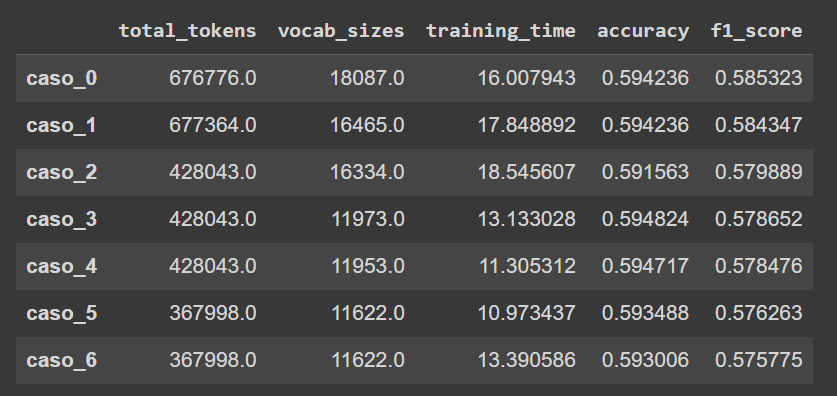

### Análisis resultados Naive Bayes

Se aplican acumulativamente las técnicas de preprocesamiento para texto:

- Case folding
- remove stop words
- stemming
- lemmatization
- remove special characters and numbers
- instead of using a 0/1 (binary) vector, use the number of times that a word occurs in the text

Cada preprocesamiento reduce la cantidad de variables predictoras de nuestro modelo, pasando de un BoW completo de 18087, a 16465 gracias Case Folding (caso 1), 11622 para el caso 5 (case folding, stop word removing, stemming, lemmatization, numbers and special characters remove). El caso 6 (caso 5 pero en lugar de variables 1/0 se incluye el conteo de ocurrencia) presenta la misma cantidad de variables predictoras que el caso 5. Gracias a esta constante reducción en la dimensionalidad del problema de clasificación se observa una constante reducción en el tiempo de entrenamiento.

Se utilizan las metodologías de preprocesamiento de texto por defecto de la famosa librería `NLTK`, un análisis más exhaustivo de diferentes versiones de este preprocesamiento y calibración de sus hyperparámetros es recomendado para futuras investigaciones.

Con respecto a las metricas del accuracy y f1-score se observa una ligera reducción a medida que se implementa cada regla de procesamiento de texto. Estas diferencias podrían no ser estadísticamente significativas al momento de aplicar k-fold cross-validation. En el caso de ser diferencias significativas, se debería analizar la posibilidad de cambio de versión o hyperparámetros de la respectiva técnica.

Una metrica alta del modelo en el analsis de sentimientos no era objetivo de este estudio, sin embargo, mediante un modelo simple se puede obtener un accuracy de 0.59, un valor considerablemente alto al compararse con el campeón de Kaggle (0.76). Se considera valioso la visualización del preprocesamiento de texto sobre la eficiencia y métricas del modelo.

## Análisis resultados RNNs

Tras los resutaldos de Naive Bayes con varios métodos de preprocesamiento, se decide evitar costo computacional en preprocesamiento ya que este parece no tener un efecto importante sobre los resultados. Se utiliza una sola técnica: GloVe, propuesta por Stanford como competencia a Word2Vec, teniendo el mismo objetivo: representar las características del lenguage natural por palabra en un vector numérico de dimensionalidad finita. Adicionalmente se incluye un embedding en todas las versiones de RNNs usadas.

Se prueban numerosas combinaciones de hyperparámetros para RNN simple, LSTM y GRU, sin tener mayor diferencia entre modelos bidireccionales LSTM y GRU. Los modelos unidireccionales presentan una caída importante en score. RNN simple presenta una caída leve pero consistente con respecto a LSTM y GRU como es de esperar dada su capacidad limitada de guardar información durante largos períodos.

El código utilizado no pudo ser encapsulado en una sola función por lo cual se muestra un HPO rudimentario, idealmente se podría realizar este proceso mediante Optimización Bayesiana si el proceso de encapsulamiento hubiese sido exitoso.

Se decide utilizar un doble proceso de embedding dado los resultados positivos obtenidos en NLP (almost) from Scratch, donde se utiliza un embedding semi-supervizado y posteriormente el embedding dentro de la red neuronal. Aplicamos un enfoque similar al utilizar un primer embedding con GloVe.

Encontramos el mejor F1-Weighted en GRU con un vector de embedding de 100 elementos, 2 capaz ocultas cada una con 25 neuronas, un dropout del 50%, batch size de 64, learning rate de 0.001 y 10 epochs. Se obtiene un score de 0.771. Nótese que la diferencia entre varios de los mejores modelos es de menos de 0.01, lo cual podría no ser estadísticamente significativo al aplicar k-fold cross validation.

Nótese que al igual que en NLP (almost) from Scratch el uso de embedding pre-entrenado tiene un efecto pequeño, cuando re-entrenamos nuestra mejor arquitectura sin dicho embedding obtener un score de 0.756.